In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt

## TODO: Remove later
_Code Refs_
https://github.com/tensorflow/tensorflow/blob/r2.0/tensorflow/lite/python/tflite_convert.py#L104
`converter_fn = lite.TFLiteConverter.from_keras_model_file
converter_kwargs["model_file"] = flags.keras_model_file`

Actual code in:
https://www.gitmemory.com/gargn

```
model = tf.saved_model.load(export_dir)
concrete_func = model.signatures[
    tf.saved_model.DEFAULT_SERVING_SIGNATURE_DEF_KEY]
concrete_func.inputs[0].set_shape([1, 28, 28])
converter = tf.lite.TFLiteConverter.from_concrete_function(concrete_func)
tflite_model = converter.convert()
open("/tmp/mnist_fashion/converted_model.tflite", "wb").write(tflite_model)
```

Note that the model has been saved with tf.saved_model, and not with keras convience function.

    

In [2]:
import sys
sys.path.append('../')  # so that we can import libs from other chapters and utils

from utils import emnist_utils

In [3]:
######## GPU CONFIGS FOR RTX 2070 ###########
## Please ignore if not training on GPU ##
from tensorflow.keras import backend as K
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True  # dont allocate all memory at once
config.gpu_options.allocator_type = 'BFC'  #A "Best-fit with coalescing" algorithm, simplified from a version of dlmalloc
config.gpu_options.per_process_gpu_memory_fraction = 2.0  # Use host memory as swap space, may not work on all architectures
config.log_device_placement=True
session = InteractiveSession(config=config)
K.set_session(session)
##########################################

In [4]:
# Load train and test data from Chapter 1 location
train = {}
test = {}

train['features'], train['labels'] = emnist_utils.read_emnist('../Chapter1/data/emnist-bymerge-train-images-idx3-ubyte.gz', '../Chapter1/data/emnist-bymerge-train-labels-idx1-ubyte.gz')
test['features'], test['labels'] = emnist_utils.read_emnist('../Chapter1/data/emnist-bymerge-test-images-idx3-ubyte.gz', '../Chapter1/data/emnist-bymerge-test-labels-idx1-ubyte.gz')

In [5]:
mappings = emnist_utils.map_emnist_labels("../Chapter1/data/emnist-bymerge-mapping.txt")

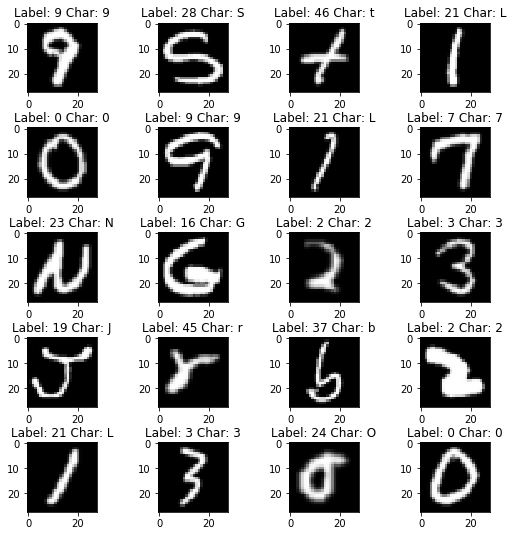

In [6]:
# Plot some images to verify we got the data right
emnist_utils.display_emnist_images(test['features'], test['labels'], mappings)

In [7]:
# Normalize the data
norm_train_features = keras.utils.normalize(train['features'])
norm_test_features = keras.utils.normalize(test['features'])

# one hot encode training labels
one_hot_train_labels = tf.one_hot(train['labels'], 47)
one_hot_test_labels = tf.one_hot(test['labels'], 47)

## Our first Convolutional Neural Network

In [8]:
# (1) First the input layer
inputs = keras.Input(shape=(28,28,), name='emnist_inp')
x = layers.Reshape((28, 28, 1))(inputs)  # since images are gray scale, they have only one channel

# (2) Learn 64 different filters, each 3x3 in size, with valid pooling, and (1,1) stride size
x = layers.Conv2D(64, (3, 3), activation='relu')(x)

# (3) Pooling layer
x = layers.MaxPooling2D(pool_size=(2, 2))(x)

# (4) Dimensions after pooling are 13x13x64. The 28x28 image is now 13x13 with 64 filters
x = layers.Flatten()(x)

# (5) Traditional dense/FC layers to use these inputs for classification
# This part is similar to previous model
x = layers.Dense(256, activation='relu', name='dense_1')(x)
x = layers.Dense(128, activation='relu', name='dense_2')(x)
outputs = layers.Dense(47, activation='softmax', name='predictions')(x)

cnn = keras.Model(inputs=inputs, outputs=outputs, name='cnn_model_1')
cnn.summary()

Model: "cnn_model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
emnist_inp (InputLayer)      [(None, 28, 28)]          0         
_________________________________________________________________
reshape (Reshape)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 10816)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2769152   
_________________________________________________________________
dense_2 (Dense)              (None, 128)               

In [9]:
# Lets compile the model and train it
cnn.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = cnn.fit(norm_train_features, one_hot_train_labels, epochs=10, batch_size=128)

In [ ]:
# Evaluate the model on the test set
cnn.evaluate(norm_test_features, one_hot_test_labels, 47)

In [11]:
# Visualize the training
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.legend(['accuracy', 'loss'], loc='right')
plt.xlabel('epoch')
plt.show()

NameError: name 'history' is not defined

In [ ]:
predictions = cnn.predict(norm_test_features)  # generates a probability for each label
y_pred = np.argmax(predictions, axis=1)  # choose the one with the highest value as the output label

print('Confusion Matrix')
confusion = emnist_utils.generate_confusion_matrix(test['labels'], y_pred)
print(confusion)
emnist_utils.plot_confusion_matrix(confusion, mappings)

## New Deeper Network
This network will be used to demonstrate use of TensorBoard and generalization techniques like dropout and batch norm.

In [13]:
# (1) First the input layer
inputs = keras.Input(shape=(28,28,), name='emnist_inp')
x = layers.Reshape((28, 28, 1))(inputs)  # since images are gray scale, they have only one channel

# (2.1) Learn 128 different filters, each 3x3 in size, with valid pooling, and (1,1) stride size
x = layers.Conv2D(128, (3, 3), activation='relu', padding="same")(x)
x = layers.Conv2D(128, (3, 3), activation='relu', padding="same")(x)  # 2 convolutional layers
# (3.1) Pooling layer
x = layers.MaxPooling2D(pool_size=(2, 2))(x)

# (2.2) Learn 64 different filters, each 3x3 in size, with valid pooling, and (1,1) stride size
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)  # 2 convolutional layers
# (3.2) Pooling layer
x = layers.MaxPooling2D(pool_size=(2, 2))(x)


# (4) Dimensions after pooling are 5x5x64. The 28x28 image is now 5x5 with 64 filters
x = layers.Flatten()(x)

# (5) Traditional dense/FC layers to use these inputs for classification
# This part is similar to previous model
x = layers.Dense(256, activation='relu', name='dense_1')(x)
x = layers.Dense(128, activation='relu', name='dense_2')(x)
outputs = layers.Dense(47, activation='softmax', name='predictions')(x)

cnn2 = keras.Model(inputs=inputs, outputs=outputs, name='cnn_model_2')
cnn2.summary()

Model: "cnn_model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
emnist_inp (InputLayer)      [(None, 28, 28)]          0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 128)       1280      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 64)        73792     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 10, 10, 64)        

### Setup TensorBoard
Main steps include setting up a location to log the data and configuring keras to call it

In [14]:
import os, datetime

# sets the log directory as a subdirectory of the folder this python notebook is store in
logs_base_dir = "./logs"  

# If the directory does not exist, create it
os.makedirs(logs_base_dir, exist_ok=True)  

# Make a subdirectory with date and time formatted string to keep track of runs
logdir = os.path.join(logs_base_dir, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

# Register a callback with Keras to call after every epoch is completed
tensorboard_callback = keras.callbacks.TensorBoard(logdir, histogram_freq=1, write_images=True)

# Creates a file writer for the log directory. Used to log the first image
file_writer = tf.summary.create_file_writer(logdir)

with file_writer.as_default():
  tf.summary.image("Training data", np.reshape(train['features'][0], (-1, 28, 28, 1)), step=0)

In [15]:
# Lets compile the model and train it
cnn2.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Note the addition of the validation data and callback in the training loop
history = cnn2.fit(norm_train_features, one_hot_train_labels,
                   epochs=10, batch_size=128,
                   validation_data=(norm_test_features, one_hot_test_labels),
                   callbacks=[tensorboard_callback])

Train on 697932 samples, validate on 116323 samples
Epoch 1/10
   128/697932 [..............................] - ETA: 1:14:22 - loss: 3.8499 - accuracy: 0.0547

W0419 00:25:38.302969 139707335010112 callbacks.py:236] Method (on_train_batch_end) is slow compared to the batch update (0.161476). Check your callbacks.


697932/697932 [==============================] - 115s 165us/sample - loss: 0.3735 - accuracy: 0.8692 - val_loss: 0.2964 - val_accuracy: 0.8896
Epoch 2/10
697932/697932 [==============================] - 114s 163us/sample - loss: 0.2682 - accuracy: 0.8998 - val_loss: 0.2683 - val_accuracy: 0.9007
Epoch 3/10
697932/697932 [==============================] - 114s 163us/sample - loss: 0.2466 - accuracy: 0.9065 - val_loss: 0.2602 - val_accuracy: 0.9037
Epoch 4/10
697932/697932 [==============================] - 114s 163us/sample - loss: 0.2326 - accuracy: 0.9106 - val_loss: 0.2606 - val_accuracy: 0.9005
Epoch 5/10
697932/697932 [==============================] - 114s 163us/sample - loss: 0.2222 - accuracy: 0.9132 - val_loss: 0.2619 - val_accuracy: 0.9041
Epoch 6/10
697932/697932 [==============================] - 114s 163us/sample - loss: 0.2134 - accuracy: 0.9157 - val_loss: 0.2607 - val_accuracy: 0.9050
Epoch 7/10
697932/697932 [==============================] - 113s 162us/sample - loss: 0

In [16]:
# Evaluate the model on the test set
cnn2.evaluate(norm_test_features, one_hot_test_labels, 47)

116323/116323 [==============================] - 10s 88us/sample - loss: 0.2828 - accuracy: 0.9022


[0.28276159200806233, 0.90216035]

Confusion Matrix
[[4591    0    3 ...    0    0    0]
 [   0 5782    3 ...    0    2    5]
 [   1    2 5627 ...    2    2    0]
 ...
 [   0    0    2 ...  257    0    0]
 [   0    5    0 ...    0 2267    5]
 [   2    4    1 ...    0    5 2818]]


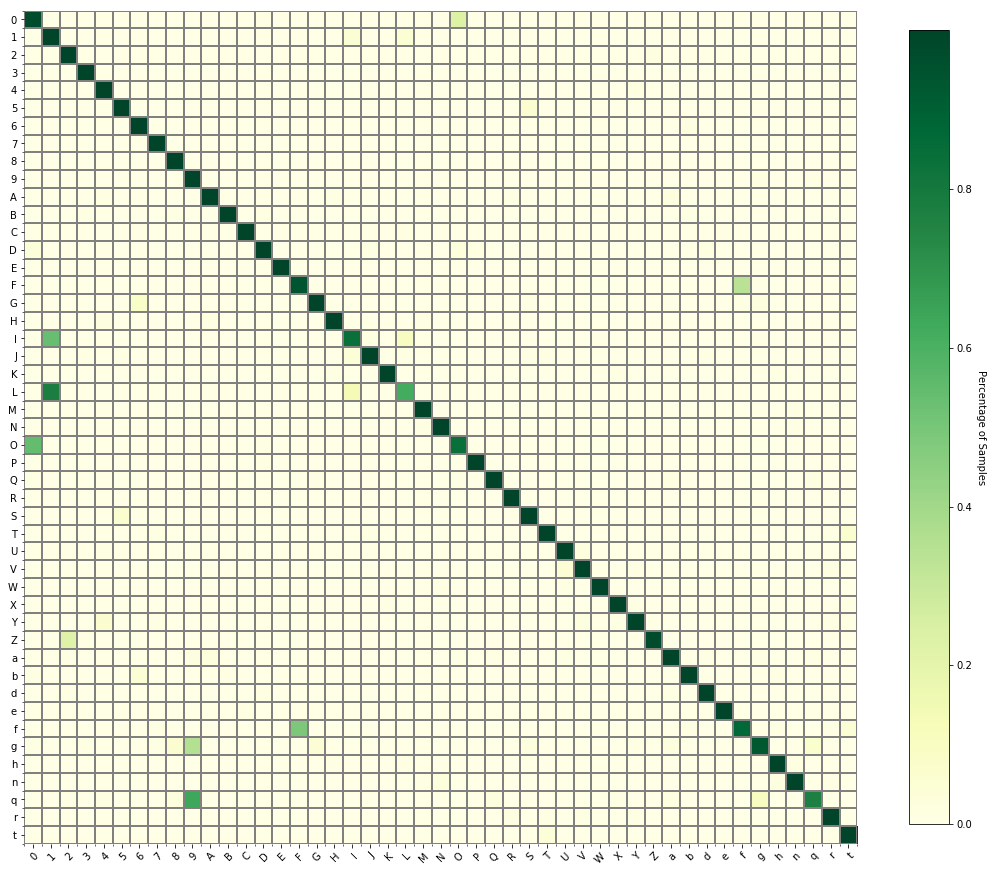

In [17]:
predictions = cnn2.predict(norm_test_features)  # generates a probability for each label
y_pred = np.argmax(predictions, axis=1)  # choose the one with the highest value as the output label

print('Confusion Matrix')
confusion = emnist_utils.generate_confusion_matrix(test['labels'], y_pred)
print(confusion)
emnist_utils.plot_confusion_matrix(confusion, mappings)

## Regularization

### L2 Regularization
This part of the notebook adds a L2 regularizer to the dense layer of the network above.

In [21]:
# (1) First the input layer
inputs = keras.Input(shape=(28,28,), name='emnist_inp')
x = layers.Reshape((28, 28, 1))(inputs)  # since images are gray scale, they have only one channel

# (2.1) Learn 128 different filters, each 3x3 in size, with valid pooling, and (1,1) stride size
x = layers.Conv2D(128, (3, 3), activation='relu', padding="same")(x)
x = layers.Conv2D(128, (3, 3), activation='relu', padding="same")(x)  # 2 convolutional layers
# (3.1) Pooling layer
x = layers.MaxPooling2D(pool_size=(2, 2))(x)

# (2.2) Learn 64 different filters, each 3x3 in size, with valid pooling, and (1,1) stride size
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)  # 2 convolutional layers
# (3.2) Pooling layer
x = layers.MaxPooling2D(pool_size=(2, 2))(x)


# (4) Dimensions after pooling are 5x5x64. The 28x28 image is now 5x5 with 64 filters
x = layers.Flatten()(x)

# (5) Traditional dense/FC layers to use these inputs for classification
# This part is similar to previous model
x = layers.Dense(256, activation='relu', 
                 kernel_regularizer=keras.regularizers.l2(l=0.001), 
                 name='dense_1')(x)
x = layers.Dense(128, activation='relu', 
                 kernel_regularizer=keras.regularizers.l2(l=0.001),
                 name='dense_2')(x)
outputs = layers.Dense(47, activation='softmax', name='predictions')(x)

cnn2_l2 = keras.Model(inputs=inputs, outputs=outputs, name='cnn_model_L2')
cnn2_l2.summary()

Model: "cnn_model_L2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
emnist_inp (InputLayer)      [(None, 28, 28)]          0         
_________________________________________________________________
reshape_3 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 28, 28, 128)       1280      
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 28, 28, 128)       147584    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 12, 12, 64)        73792     
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 10, 10, 64)       

In [22]:
# Setup TensorBoard logging
# Make a subdirectory with date and time formatted string to keep track of runs
logdir = os.path.join(logs_base_dir, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

# Register a callback with Keras to call after every epoch is completed
tensorboard_callback = keras.callbacks.TensorBoard(logdir, histogram_freq=1, write_images=True)

# Creates a file writer for the log directory. Used to log the first image
file_writer = tf.summary.create_file_writer(logdir)

#with file_writer.as_default():
#  tf.summary.image("Training data", np.reshape(train['features'][0], (-1, 28, 28, 1)), step=0)

In [23]:
# Lets compile the model and train it
cnn2_l2.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# take a small part of the test set as a validation set
val_test_features = norm_test_features[:5000]  # there are 116K test samples
val_test_labels = one_hot_test_labels[:5000]

# Note the addition of the validation data and callback in the training loop
history = cnn2_l2.fit(norm_train_features, one_hot_train_labels,
                   epochs=10, batch_size=128,
                   validation_data=(val_test_features, val_test_labels),
                   callbacks=[tensorboard_callback])

Train on 697932 samples, validate on 5000 samples
Epoch 1/10
697932/697932 [==============================] - 109s 156us/sample - loss: 0.5136 - accuracy: 0.8646 - val_loss: 0.3810 - val_accuracy: 0.8928
Epoch 2/10
697932/697932 [==============================] - 109s 156us/sample - loss: 0.3651 - accuracy: 0.8903 - val_loss: 0.3473 - val_accuracy: 0.8960
Epoch 3/10
697932/697932 [==============================] - 109s 156us/sample - loss: 0.3376 - accuracy: 0.8955 - val_loss: 0.3223 - val_accuracy: 0.8970
Epoch 4/10
697932/697932 [==============================] - 109s 156us/sample - loss: 0.3236 - accuracy: 0.8981 - val_loss: 0.3089 - val_accuracy: 0.9034
Epoch 5/10
697932/697932 [==============================] - 109s 156us/sample - loss: 0.3138 - accuracy: 0.9002 - val_loss: 0.3042 - val_accuracy: 0.9042
Epoch 6/10
697932/697932 [==============================] - 109s 156us/sample - loss: 0.3068 - accuracy: 0.9013 - val_loss: 0.3118 - val_accuracy: 0.8988
Epoch 7/10
697932/697932 [

In [24]:
# Evaluate the model on the test set
cnn2_l2.evaluate(norm_test_features, one_hot_test_labels, 47)

116323/116323 [==============================] - 11s 92us/sample - loss: 0.3089 - accuracy: 0.9001


[0.3089260218638535, 0.90011436]

## Dropout Based Regularization

In [30]:
import os, datetime
# Setup TensorBoard logging
# Make a subdirectory with date and time formatted string to keep track of runs
logdir = os.path.join(logs_base_dir, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

# Register a callback with Keras to call after every epoch is completed
tensorboard_callback = keras.callbacks.TensorBoard(logdir, histogram_freq=1, write_images=True)

# Creates a file writer for the log directory. Used to log the first image
file_writer = tf.summary.create_file_writer(logdir)

In [31]:
# (1) First the input layer
inputs = keras.Input(shape=(28,28,), name='emnist_inp')
x = layers.Reshape((28, 28, 1))(inputs)  # since images are gray scale, they have only one channel

# (2.1) Learn 128 different filters, each 3x3 in size, with valid pooling, and (1,1) stride size
x = layers.Conv2D(128, (3, 3), activation='relu', padding="same")(x)
x = layers.Conv2D(128, (3, 3), activation='relu', padding="same")(x)  # 2 convolutional layers
# (3.1) Pooling layer
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
# (4.1) Dropout Layer, dropping 20% of the connection
x = layers.Dropout(0.2)(x) 

# (2.2) Learn 64 different filters, each 3x3 in size, with valid pooling, and (1,1) stride size
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)  # 2 convolutional layers
# (3.2) Pooling layer
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
# (4.2) Dropout Layer, dropping 20% of the connection
x = layers.Dropout(0.2)(x) 

# (4) Dimensions after pooling are 5x5x64. The 28x28 image is now 5x5 with 64 filters
x = layers.Flatten()(x)

# (5) Traditional dense/FC layers to use these inputs for classification
# This part is similar to previous model
x = layers.Dense(256, activation='relu', name='dense_1')(x)
x = layers.Dense(128, activation='relu', name='dense_2')(x)

outputs = layers.Dense(47, activation='softmax', name='predictions')(x)

cnn2_dropout = keras.Model(inputs=inputs, outputs=outputs, name='cnn_model_dropout')
cnn2_dropout.summary()

Model: "cnn_model_dropout"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
emnist_inp (InputLayer)      [(None, 28, 28)]          0         
_________________________________________________________________
reshape_7 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 28, 28, 128)       1280      
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 28, 28, 128)       147584    
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 14, 14, 128)       0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 12, 12, 64)  

In [34]:
# Lets compile the model and train it
cnn2_dropout.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# take a small part of the test set as a validation set
val_test_features = norm_test_features[:5000]  # there are 116K test samples
val_test_labels = one_hot_test_labels[:5000]

# Note the addition of the validation data and callback in the training loop
history = cnn2_dropout.fit(norm_train_features, one_hot_train_labels,
                   epochs=10, batch_size=128,
                   validation_data=(val_test_features, val_test_labels)
                          ) #,
                  # callbacks=[tensorboard_callback])

Train on 697932 samples, validate on 5000 samples
Epoch 1/10
697932/697932 [==============================] - 117s 168us/sample - loss: 0.2538 - accuracy: 0.9043 - val_loss: 0.2470 - val_accuracy: 0.9094
Epoch 2/10
697932/697932 [==============================] - 117s 168us/sample - loss: 0.2432 - accuracy: 0.9071 - val_loss: 0.2450 - val_accuracy: 0.9078
Epoch 3/10
697932/697932 [==============================] - 117s 168us/sample - loss: 0.2375 - accuracy: 0.9085 - val_loss: 0.2494 - val_accuracy: 0.9060
Epoch 4/10
697932/697932 [==============================] - 117s 168us/sample - loss: 0.2333 - accuracy: 0.9098 - val_loss: 0.2444 - val_accuracy: 0.9102
Epoch 5/10
697932/697932 [==============================] - 117s 168us/sample - loss: 0.2301 - accuracy: 0.9103 - val_loss: 0.2423 - val_accuracy: 0.9070
Epoch 6/10
697932/697932 [==============================] - 117s 168us/sample - loss: 0.2272 - accuracy: 0.9112 - val_loss: 0.2419 - val_accuracy: 0.9100
Epoch 7/10
697932/697932 [

In [36]:
# Evaluate the model on the test set
cnn2_dropout.evaluate(norm_test_features, one_hot_test_labels, 47)

116323/116323 [==============================] - 10s 88us/sample - loss: 0.2588 - accuracy: 0.9069


[0.25879781841594607, 0.9068714]

## Batch Normalization
Adding batchnormalization in the network

In [20]:
import os, datetime

# sets the log directory as a subdirectory of the folder this python notebook is store in
logs_base_dir = "./logs"  

# If the directory does not exist, create it
os.makedirs(logs_base_dir, exist_ok=True)  

# Make a subdirectory with date and time formatted string to keep track of runs
logdir = os.path.join(logs_base_dir, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

# Register a callback with Keras to call after every epoch is completed
tensorboard_callback = keras.callbacks.TensorBoard(logdir, histogram_freq=1, write_images=True)

# Creates a file writer for the log directory. Used to log the first image
file_writer = tf.summary.create_file_writer(logdir)


In [21]:
# (1) First the input layer
inputs = keras.Input(shape=(28,28,), name='emnist_inp')
x = layers.Reshape((28, 28, 1))(inputs)  # since images are gray scale, they have only one channel

# (2.1) Learn 128 different filters, each 3x3 in size, with valid pooling, and (1,1) stride size
x = layers.Conv2D(128, (3, 3), activation='relu', padding="same")(x)
# (5.1) BatchNormalization added between conv layer
x = layers.BatchNormalization()(x)
# (4.1) Dropout Layer, dropping 20% of the connection
x = layers.Dropout(0.2)(x) 

x = layers.Conv2D(128, (3, 3), activation='relu', padding="same")(x)  # 2 convolutional layers
# (5.2) BatchNormalization added between conv layer
x = layers.BatchNormalization()(x)
# (4.2) Dropout Layer, dropping 20% of the connection
x = layers.Dropout(0.2)(x)

# (3.1) Pooling layer
x = layers.MaxPooling2D(pool_size=(2, 2))(x)


# (2.2) Learn 64 different filters, each 3x3 in size, with valid pooling, and (1,1) stride size
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
# (5.3) BatchNormalization added between conv layer
x = layers.BatchNormalization()(x)
# (4.3) Dropout Layer, dropping 20% of the connection
x = layers.Dropout(0.2)(x) 

x = layers.Conv2D(64, (3, 3), activation='relu')(x)  # 2 convolutional layers
# (5.4) BatchNormalization added between conv layer
x = layers.BatchNormalization()(x)
# (4.4) Dropout Layer, dropping 20% of the connection
x = layers.Dropout(0.2)(x) 

# (3.2) Pooling layer
x = layers.MaxPooling2D(pool_size=(2, 2))(x)

# (6) Dimensions after pooling are 5x5x64. The 28x28 image is now 5x5 with 64 filters
x = layers.Flatten()(x)

# (7) Traditional dense/FC layers to use these inputs for classification
# This part is similar to previous model
x = layers.Dense(256, activation='relu', name='dense_1')(x)
x = layers.Dense(128, activation='relu', name='dense_2')(x)

outputs = layers.Dense(47, activation='softmax', name='predictions')(x)

cnn2_do_bn = keras.Model(inputs=inputs, outputs=outputs, name='cnn_model_dropout_batch_norm')
cnn2_do_bn.summary()

Model: "cnn_model_dropout_batch_norm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
emnist_inp (InputLayer)      [(None, 28, 28)]          0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 128)       1280      
_________________________________________________________________
batch_normalization_v2_3 (Ba (None, 28, 28, 128)       512       
_________________________________________________________________
dropout_3 (Dropout)          (None, 28, 28, 128)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 128)       147584    
_________________________________________________________________
batch_normalization_v2_4 (Ba (None, 28

In [ ]:
# Lets compile the model and train it
cnn2_do_bn.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# take a small part of the test set as a validation set
val_test_features = norm_test_features[:5000]  # there are 116K test samples
val_test_labels = one_hot_test_labels[:5000]

# Note the addition of the validation data
# Callback for TensorBoard removed for speeding up training
history = cnn2_do_bn.fit(norm_train_features, one_hot_train_labels,
                   epochs=15, batch_size=128,
                   validation_data=(val_test_features, val_test_labels)
                          ) 

In [19]:
# Evaluate the model on the test set
cnn2_do_bn.evaluate(norm_test_features, one_hot_test_labels, 47)

116323/116323 [==============================] - 11s 96us/sample - loss: 0.2539 - accuracy: 0.9079


[0.25391521276240725, 0.9079202]

## Data Augmentation
Lets add more training for some characters from the confusion matrix and retrain the Batchnorm model from above.

### Analyse counts for characters with low accuracy

In [11]:
# Lets get number of samples for 'L', 'I', 'q', and 'g'
from collections import Counter

training_dist = Counter(train['labels'])  # count all the occurences
for x in mappings:
    # look through to find the letters and print their count
    if mappings[x] in ('L', 'I', 'q', 'g'):
        print(mappings[x], ' (', x,  "): ", training_dist[x])

I  ( 18 ):  14733
L  ( 21 ):  20381
g  ( 41 ):  3693
q  ( 44 ):  2966


In [12]:
# Now lets do some transforms to 'q' and add it back to the training set
# tf.image provides a set of methods to run to add new samples

q = [train['labels'] == 41]  # mask of all training images corresponding to 'q' as a list

q_labels = np.compress(np.array(q).squeeze(), train['labels'], axis=0)
q_data = np.compress(np.array(q).squeeze(), train['features'], axis=0)  # selecting all 'q' images out
print(q_data.shape, q_labels.shape)  # just checking for the right dimensions and numbers
# Expected result is (3693 28, 28) (3693,)

(3693, 28, 28) (3693,)


In [84]:
# Same thing for 'L'
L = [train['labels'] == 21]  # mask of all training images corresponding to 'L' as a list
#l_labels = np.compress(np.array(L).squeeze(), train['labels'], axis=0)
#l_data = np.compress(np.array(L).squeeze(), train['features'], axis=0)  # selecting all 'q' images out
#print(l_data.shape, l_labels.shape)  # just checking for the right dimensions and numbers
# Expected result is (3693 28, 28) (3693,)

In [13]:
# Now lets use the tf.image package to create variants
sam, h, w = q_data.shape
q_data = np.reshape(q_data, [sam, h, w, 1])  # TF methods expect atleast 1 channel 
#q_data_brightness = tf.image.random_brightness(q_data, 0.6, seed=9)  # random seed for reproducibility
#q_data_contrast = tf.image.random_contrast(q_data, 0.2, 0.8, seed=9)  # random seed for reproducibility
q_data_brightness = tf.image.adjust_brightness(q_data, 0.1)
q_data_contrast = tf.image.adjust_contrast(q_data, 0.1)
q_data_gamma = tf.image.adjust_gamma(q_data, gamma=3.0)  # make it bright
q_data_gamma_2 = tf.image.adjust_gamma(q_data, gamma=0.3)
q_data_flip = tf.image.random_flip_up_down(q_data, seed=9)
#print(q_data_brightness[1], [28, 28])
print(q_data_brightness.shape)

(3693, 28, 28)
tf.Tensor(
[[[1.00000001e-01]
  [1.00000001e-01]
  [1.00000001e-01]
  [1.00000001e-01]
  [1.00000001e-01]
  [1.00000001e-01]
  [1.00000001e-01]
  [1.00000001e-01]
  [1.00000001e-01]
  [1.00000001e-01]
  [1.00000001e-01]
  [1.00000001e-01]
  [1.00000001e-01]
  [1.00000001e-01]
  [1.00000001e-01]
  [1.00000001e-01]
  [1.00000001e-01]
  [1.00000001e-01]
  [1.00000001e-01]
  [1.00000001e-01]
  [1.00000001e-01]
  [1.00000001e-01]
  [1.00000001e-01]
  [1.00000001e-01]
  [1.00000001e-01]
  [1.00000001e-01]
  [1.00000001e-01]
  [1.00000001e-01]]

 [[1.00000001e-01]
  [1.00000001e-01]
  [1.00000001e-01]
  [1.00000001e-01]
  [1.00000001e-01]
  [1.00000001e-01]
  [1.00000001e-01]
  [1.00000001e-01]
  [1.00000001e-01]
  [1.00000001e-01]
  [1.00000001e-01]
  [1.00000001e-01]
  [1.00000001e-01]
  [1.00000001e-01]
  [1.00000001e-01]
  [1.00000001e-01]
  [2.09999990e+00]
  [4.09999990e+00]
  [2.09999990e+00]
  [1.00000001e-01]
  [1.00000001e-01]
  [1.00000001e-01]
  [1.00000001e-01]
  [

In [15]:
img_num = 5
sample = q_data_brightness[img_num].numpy()
sample.shape
sample = np.reshape(sample, [28,28])

sample2 = q_data_contrast[img_num].numpy()
sample2 = np.reshape(sample2, [28,28])

sample3 = q_data_flip[img_num].numpy() 
sample3 = np.reshape(sample3, [28,28])

sample4 = np.reshape(q_data_gamma[img_num].numpy(), [28,28])

sample5 = np.reshape(q_data_gamma_2[img_num].numpy(), [28,28])


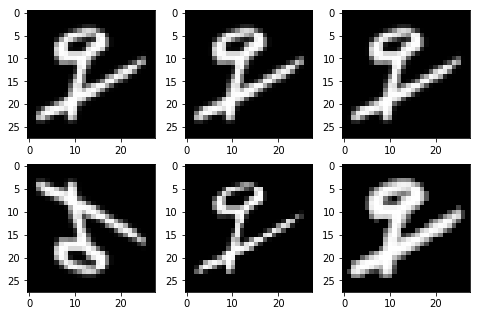

In [16]:
fig=plt.figure(figsize=(8, 8))
row, col = (3, 3)

fig.add_subplot(row, col, 1)
plt.imshow(q_data[img_num].squeeze(), cmap='gray')

fig.add_subplot(row, col, 2)
plt.imshow(sample, cmap='gray')

fig.add_subplot(row, col, 3)
plt.imshow(sample2, cmap='gray')

fig.add_subplot(row, col, 4)
plt.imshow(sample3, cmap='gray')

fig.add_subplot(row, col, 5)
plt.imshow(sample4, cmap='gray')

fig.add_subplot(row, col, 6)
plt.imshow(sample5, cmap='gray')

plt.show()


In [17]:
# Lets add these augmented 'q' samples 

aug_data = np.concatenate((train['features'], q_data_gamma.numpy().squeeze()))
aug_labels = np.concatenate((train['labels'], q_labels))

# lets check dimensions
print(aug_data.shape, aug_labels.shape)
#expected answer is 697932+3693 = 701625

# Normalize the data
norm_aug_train_features = keras.utils.normalize(aug_data)

# one hot encode training labels
one_hot_aug_train_labels = tf.one_hot(aug_labels, 47)

print(type(norm_aug_train_features))

(701625, 28, 28) (701625,)
<class 'numpy.ndarray'>


In [42]:
# (1) First the input layer
inputs = keras.Input(shape=(28, 28, 1,), name='emnist_inp')
x = layers.Reshape((28, 28, 1))(inputs)  # since images are gray scale, they have only one channel

# (2.1) Learn 128 different filters, each 3x3 in size, with valid pooling, and (1,1) stride size
x = layers.Conv2D(128, (3, 3), activation='relu', padding="same")(x)
# (5.1) BatchNormalization added between conv layer
x = layers.BatchNormalization()(x)
# (4.1) Dropout Layer, dropping 20% of the connection
x = layers.Dropout(0.2)(x) 


x = layers.Conv2D(128, (3, 3), activation='relu', padding="same")(x)  # 2 convolutional layers
# (5.2) BatchNormalization added between conv layer
x = layers.BatchNormalization()(x)
# (4.2) Dropout Layer, dropping 20% of the connection
x = layers.Dropout(0.2)(x)

# (3.1) Pooling layer
x = layers.MaxPooling2D(pool_size=(2, 2))(x)


# (2.2) Learn 64 different filters, each 3x3 in size, with valid pooling, and (1,1) stride size
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
# (5.3) BatchNormalization added between conv layer
x = layers.BatchNormalization()(x)
# (4.3) Dropout Layer, dropping 20% of the connection
x = layers.Dropout(0.2)(x) 

x = layers.Conv2D(64, (3, 3), activation='relu')(x)  # 2 convolutional layers
# (5.4) BatchNormalization added between conv layer
x = layers.BatchNormalization()(x)
# (4.4) Dropout Layer, dropping 20% of the connection
x = layers.Dropout(0.2)(x) 

# (3.2) Pooling layer
x = layers.MaxPooling2D(pool_size=(2, 2))(x)

# (6) Dimensions after pooling are 5x5x64. The 28x28 image is now 5x5 with 64 filters
x = layers.Flatten()(x)

# (7) Traditional dense/FC layers to use these inputs for classification
# This part is similar to previous model
x = layers.Dense(256, activation='relu', name='dense_1')(x)
x = layers.Dense(128, activation='relu', name='dense_2')(x)

outputs = layers.Dense(47, activation='softmax', name='predictions')(x)

cnn2_do_bn_dataug = keras.Model(inputs=inputs, outputs=outputs, name='cnn_dropout_batch_norm_data_augmented')
cnn2_do_bn_dataug.summary()

Model: "cnn_dropout_batch_norm_data_augmented"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
emnist_inp (InputLayer)      [(None, 28, 28, 1)]       0         
_________________________________________________________________
reshape_6 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 28, 28, 128)       1280      
_________________________________________________________________
batch_normalization_v2_16 (B (None, 28, 28, 128)       512       
_________________________________________________________________
dropout_16 (Dropout)         (None, 28, 28, 128)       0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 28, 28, 128)       147584    
_________________________________________________________________
batch_normalization_v2_17 (B 

### Using `keras.preprocessing` for Data Augmentation

In [44]:
# Lets compile the model and train it
cnn2_do_bn_dataug.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# try Keras fit generator pre-processing methods
datagen = keras.preprocessing.image.ImageDataGenerator(
    samplewise_center=True,
    samplewise_std_normalization=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=(0.2, 0.8)
    )

# reshape data for use
n_sampl, h, w = train['features'].shape
train_data = np.reshape(train['features'], (n_sampl, h, w, 1))

# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
datagen.fit(train_data, augment=True, rounds=2)

# now pass through the model
batch_size = 128
epochs = 10

cnn2_do_bn_dataug.fit_generator(datagen.flow(train_data, one_hot_train_labels, batch_size=batch_size),
                    steps_per_epoch=len(train['features']) / batch_size, epochs=epochs)

Epoch 1/10
5453/5452 [==============================] - 371s 68ms/step - loss: 0.4768 - accuracy: 0.8399
Epoch 2/10
5453/5452 [==============================] - 365s 67ms/step - loss: 0.3279 - accuracy: 0.8819
Epoch 3/10
5453/5452 [==============================] - 365s 67ms/step - loss: 0.3058 - accuracy: 0.8886
Epoch 4/10
5453/5452 [==============================] - 365s 67ms/step - loss: 0.2922 - accuracy: 0.8928
Epoch 5/10
5453/5452 [==============================] - 364s 67ms/step - loss: 0.2832 - accuracy: 0.8953
Epoch 6/10
 503/5452 [=>............................] - ETA: 5:29 - loss: 0.2726 - accuracy: 0.8976

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



5453/5452 [==============================] - 363s 67ms/step - loss: 0.2709 - accuracy: 0.8988
Epoch 8/10
5453/5452 [==============================] - 364s 67ms/step - loss: 0.2673 - accuracy: 0.8999
Epoch 9/10
5453/5452 [==============================] - 364s 67ms/step - loss: 0.2643 - accuracy: 0.9007
Epoch 10/10
5453/5452 [==============================] - 363s 67ms/step - loss: 0.2615 - accuracy: 0.9016


In [45]:
datagen = keras.preprocessing.image.ImageDataGenerator(
    samplewise_center=True,
    samplewise_std_normalization=True,
    )

# reshape data for use
n_sampl, h, w = test['features'].shape
test_data = np.reshape(test['features'], (n_sampl, h, w, 1))

# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
datagen.fit(test_data)

# reshape testing data
#n_test, h, w = norm_test_features.shape
#test_data = np.reshape(norm_test_features, (n_test, h, w, 1))

# Evaluate the model on the test set
cnn2_do_bn_dataug.evaluate_generator(datagen.flow(test_data, one_hot_test_labels))

[0.2721694593575995, 0.89104474]

## Changing gamma by hand

In [ ]:
# encoded = ((original / 255) ^ (1 / gamma)) * 255
# now take a sample image and code it using this gamma formula
gamma1 = 0.33
gamma2 = 2.0

def enhance_gamma(img, gamma):
    return ((img / 255.) ** (1 / gamma)) * 255.


In [50]:
dull_q = enhance_gamma(q_data, gamma1)  # makes the image duller
bright_q = enhance_gamma(q_data, gamma2)  # makes the image brighter / higher luminosity

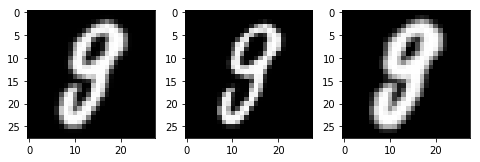

In [51]:
fig=plt.figure(figsize=(8, 8))
row, col = (3, 3)

fig.add_subplot(row, col, 1)
plt.imshow(q_data[1].squeeze(), cmap='gray')

fig.add_subplot(row, col, 2)
plt.imshow(dull_q[1].squeeze(), cmap='gray')

fig.add_subplot(row, col, 3)
plt.imshow(bright_q[1].squeeze(), cmap='gray')

In [66]:
gamma_train = np.concatenate((train['features'], dull_q.squeeze(), bright_q.squeeze()))
gamma_train_labels = np.concatenate((train['labels'], q_labels, q_labels))

# normalize the data and convert labels to one hot encoded
gamma_train_norm = keras.utils.normalize(gamma_train)

# one hot encode training labels
one_hot_gamma_train_labels = tf.one_hot(gamma_train_labels, 47)


In [59]:
# (1) First the input layer
inputs = keras.Input(shape=(28, 28,), name='emnist_inp')
x = layers.Reshape((28, 28, 1))(inputs)  # since images are gray scale, they have only one channel

# (2.1) Learn 128 different filters, each 3x3 in size, with valid pooling, and (1,1) stride size
x = layers.Conv2D(128, (3, 3), activation='relu', padding="same")(x)
# (5.1) BatchNormalization added between conv layer
x = layers.BatchNormalization()(x)
# (4.1) Dropout Layer, dropping 20% of the connection
x = layers.Dropout(0.2)(x) 


x = layers.Conv2D(128, (3, 3), activation='relu', padding="same")(x)  # 2 convolutional layers
# (5.2) BatchNormalization added between conv layer
x = layers.BatchNormalization()(x)
# (4.2) Dropout Layer, dropping 20% of the connection
x = layers.Dropout(0.2)(x)

# (3.1) Pooling layer
x = layers.MaxPooling2D(pool_size=(2, 2))(x)


# (2.2) Learn 64 different filters, each 3x3 in size, with valid pooling, and (1,1) stride size
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
# (5.3) BatchNormalization added between conv layer
x = layers.BatchNormalization()(x)
# (4.3) Dropout Layer, dropping 20% of the connection
x = layers.Dropout(0.2)(x) 

x = layers.Conv2D(64, (3, 3), activation='relu')(x)  # 2 convolutional layers
# (5.4) BatchNormalization added between conv layer
x = layers.BatchNormalization()(x)
# (4.4) Dropout Layer, dropping 20% of the connection
x = layers.Dropout(0.2)(x) 

# (3.2) Pooling layer
x = layers.MaxPooling2D(pool_size=(2, 2))(x)

# (6) Dimensions after pooling are 5x5x64. The 28x28 image is now 5x5 with 64 filters
x = layers.Flatten()(x)

# (7) Traditional dense/FC layers to use these inputs for classification
# This part is similar to previous model
x = layers.Dense(256, activation='relu', name='dense_1')(x)
x = layers.Dense(128, activation='relu', name='dense_2')(x)

outputs = layers.Dense(47, activation='softmax', name='predictions')(x)

cnn2_do_bn_dataug = keras.Model(inputs=inputs, outputs=outputs, name='cnn_dropout_batch_norm_data_augmented')
cnn2_do_bn_dataug.summary()

Model: "cnn_dropout_batch_norm_data_augmented"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
emnist_inp (InputLayer)      [(None, 28, 28)]          0         
_________________________________________________________________
reshape_7 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 28, 28, 128)       1280      
_________________________________________________________________
batch_normalization_v2_20 (B (None, 28, 28, 128)       512       
_________________________________________________________________
dropout_20 (Dropout)         (None, 28, 28, 128)       0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 28, 28, 128)       147584    
_________________________________________________________________
batch_normalization_v2_21 (B 

In [78]:
# Lets compile the model and train it
cnn2_do_bn_dataug.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# take a small part of the test set as a validation set
val_test_features = norm_test_features[:5000]  # there are 116K test samples
val_test_labels = one_hot_test_labels[:5000]

# Note the addition of the validation data
# Callback for TensorBoard removed for speeding up training
history = cnn2_do_bn_dataug.fit(gamma_train_norm, one_hot_gamma_train_labels,
                   epochs=15, batch_size=128,
                   validation_data=(val_test_features, val_test_labels)
                          ) 

Train on 705318 samples, validate on 5000 samples
Epoch 1/15
705318/705318 [==============================] - 191s 271us/sample - loss: 0.1883 - accuracy: 0.9236 - val_loss: 0.2598 - val_accuracy: 0.9106
Epoch 2/15
705318/705318 [==============================] - 190s 270us/sample - loss: 0.1873 - accuracy: 0.9239 - val_loss: 0.2633 - val_accuracy: 0.9106
Epoch 3/15
705318/705318 [==============================] - 190s 270us/sample - loss: 0.1857 - accuracy: 0.9244 - val_loss: 0.2546 - val_accuracy: 0.9116
Epoch 4/15
705318/705318 [==============================] - 190s 270us/sample - loss: 0.1838 - accuracy: 0.9249 - val_loss: 0.2676 - val_accuracy: 0.9070
Epoch 5/15
705318/705318 [==============================] - 190s 270us/sample - loss: 0.1832 - accuracy: 0.9251 - val_loss: 0.2625 - val_accuracy: 0.9092
Epoch 6/15
705318/705318 [==============================] - 190s 270us/sample - loss: 0.1821 - accuracy: 0.9254 - val_loss: 0.2665 - val_accuracy: 0.9086
Epoch 7/15
705318/705318 [

In [79]:
# Evaluate the model on the test set
cnn2_do_bn_dataug.evaluate(norm_test_features, one_hot_test_labels, 47)

116323/116323 [==============================] - 11s 97us/sample - loss: 0.2837 - accuracy: 0.9039


[0.28372658127234535, 0.9038711]

Confusion Matrix
[[3994    0    3 ...    0    0    0]
 [   0 5476    5 ...    0    1    1]
 [   1    1 5503 ...    0    3    0]
 ...
 [   0    0    1 ...  246    0    1]
 [   0    4    0 ...    0 2246    5]
 [   1    2    1 ...    0    8 2818]]


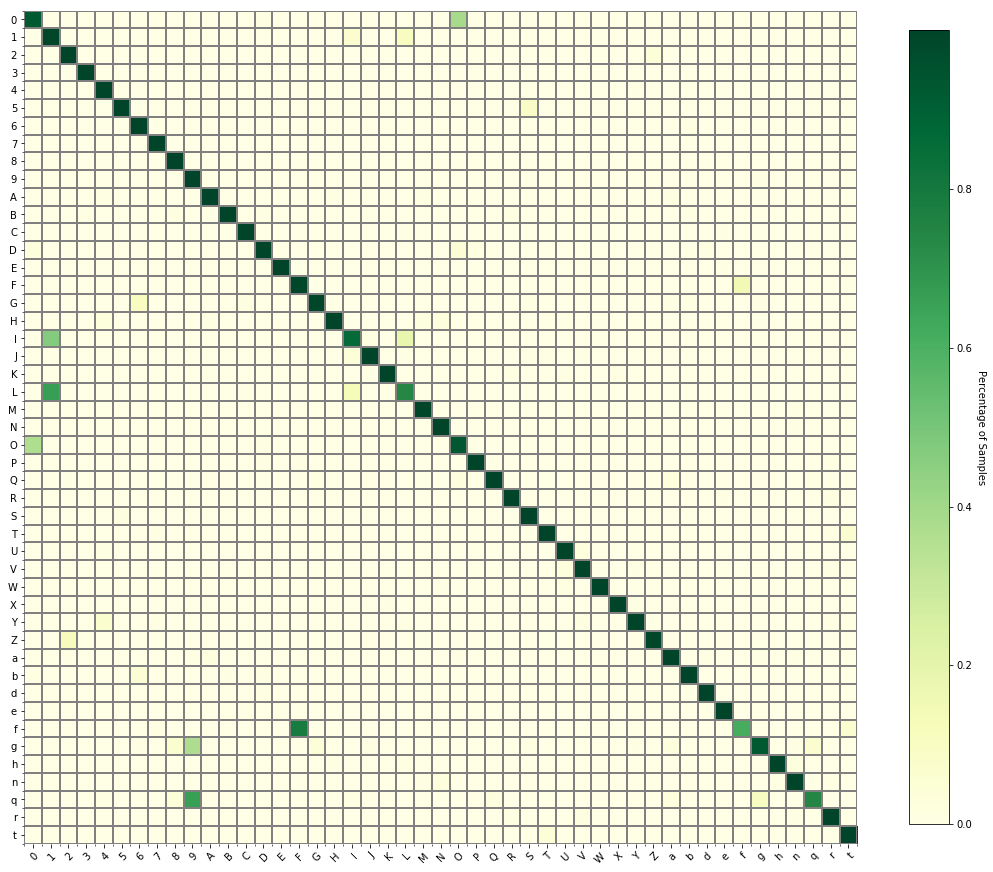

In [80]:
# Plot confusion matrix
predictions = cnn2_do_bn_dataug.predict(norm_test_features)  # generates a probability for each label
y_pred = np.argmax(predictions, axis=1)  # choose the one with the highest value as the output label

print('Confusion Matrix')
confusion = emnist_utils.generate_confusion_matrix(test['labels'], y_pred)
print(confusion)
emnist_utils.plot_confusion_matrix(confusion, mappings)

## Saving as a Mobile Model
Lets save the last trained model into a mobile model

In [20]:
cnn2_do_bn.summary()

Model: "cnn_model_dropout_batch_norm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
emnist_inp (InputLayer)      [(None, 28, 28)]          0         
_________________________________________________________________
reshape_3 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 28, 28, 128)       1280      
_________________________________________________________________
batch_normalization_v2_14 (B (None, 28, 28, 128)       512       
_________________________________________________________________
dropout_16 (Dropout)         (None, 28, 28, 128)       0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 28, 28, 128)       147584    
_________________________________________________________________
batch_normalization_v2_15 (B (None, 28

In [32]:
# lets save the last trained model using batch normalization
cnn2_do_bn.save("./models/mobile_cnn_model.h5")

In [44]:
# TODO: works on TF nightly, not on TF 2.0-alpha
converter = tf.lite.TFLiteConverter.from_keras_model_file("./models/mobile_cnn_model.h5")
tflite_model = converter.convert()
open("./models/converted_cnn_bn_model.tflite", "wb").write(tflite_model)

AttributeError: type object 'TFLiteConverterV2' has no attribute 'from_keras_model_file'

### Load the model and try some inference

In [37]:
interpreter = tf.lite.Interpreter(model_path="./models/converted_cnn_bn_model.tflite")
interpreter.allocate_tensors()

In [40]:
# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input shapes:", input_details)
print("Outut shapes:", output_details)

# Test the TensorFlow Lite model on random input data.
input_shape = input_details[0]['shape']
input_data = np.array(np.random.random_sample(input_shape), dtype=np.float32)
interpreter.set_tensor(input_details[0]['index'], input_data)

interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

Input shapes: [{'name': 'emnist_inp', 'index': 34, 'shape': array([ 1, 28, 28], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0)}]
Outut shapes: [{'name': 'predictions/Softmax', 'index': 39, 'shape': array([ 1, 47], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0)}]


In [43]:
# Test the TensorFlow model on random input data.
tf_results = cnn2_do_bn(tf.constant(input_data))

print("Mobile model results:", tflite_results)
print("Original model results:", tf_results)
# Compare the result.
for tf_result, tflite_result in zip(tf_results, tflite_results):
  np.testing.assert_almost_equal(tf_result, tflite_result, decimal=5)

Mobile model results: [[3.45591680e-36 2.82365165e-36 1.04979121e-26 1.76943150e-13
  8.57534020e-27 1.68182818e-12 2.75268268e-40 0.00000000e+00
  3.10885645e-02 2.66832266e-16 1.32626798e-23 2.15072348e-03
  1.72513854e-41 6.26304406e-27 3.88317096e-24 1.22825206e-20
  2.33015958e-16 0.00000000e+00 4.36421442e-18 3.78260715e-26
  4.45599430e-35 1.18527311e-07 4.48415509e-44 0.00000000e+00
  1.15088643e-40 2.03880707e-24 4.42444554e-32 6.54498236e-36
  1.89456155e-20 0.00000000e+00 0.00000000e+00 0.00000000e+00
  2.04641848e-33 5.91347952e-43 2.31140420e-20 7.70187788e-21
  2.06767721e-24 4.93301856e-18 1.83849111e-38 8.96652496e-30
  3.32817354e-39 9.66760635e-01 7.08484804e-25 4.65931739e-41
  9.87645843e-17 1.41391015e-42 7.57810102e-37]]
Original model results: tf.Tensor(
[[3.4560201e-36 2.8237356e-36 1.0497985e-26 1.7694437e-13 8.5753988e-27
  1.6818398e-12 0.0000000e+00 0.0000000e+00 3.1089133e-02 2.6683616e-16
  1.3262973e-23 2.1507957e-03 0.0000000e+00 6.2630876e-27 3.8831974e

In [56]:
np.argmax(np.max(tf_results, axis=1))

0

In [55]:
np.argmax(np.max(tflite_results, axis=1))

0

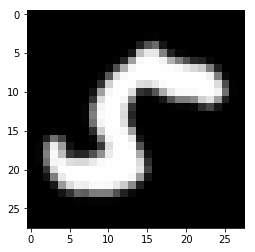

In [73]:
plt.imshow(test['features'][100].squeeze(), cmap='gray')

In [74]:
interpreter = tf.lite.Interpreter(model_path="./models/converted_cnn_bn_model.tflite")
interpreter.allocate_tensors()
# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input shapes:", input_details)
print("Outut shapes:", output_details)

# Test the TensorFlow Lite model on random input data.
input_shape = input_details[0]['shape']
input_data = np.array(np.reshape(norm_test_features[100], (1, 28, 28)), dtype=np.float32)
interpreter.set_tensor(input_details[0]['index'], input_data)

interpreter.invoke()
tflite_results2 = interpreter.get_tensor(output_details[0]['index'])

Input shapes: [{'name': 'emnist_inp', 'index': 34, 'shape': array([ 1, 28, 28], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0)}]
Outut shapes: [{'name': 'predictions/Softmax', 'index': 39, 'shape': array([ 1, 47], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0)}]


In [80]:
np.argmax(np.max(tflite_results2, axis=0))

5

In [76]:
tf_results = cnn2_do_bn.predict(np.reshape(norm_test_features[100], (1, 28, 28)))

In [79]:
np.argmax(np.max(tf_results, axis=0))

5

In [78]:
one_hot_test_labels[100]

<tf.Tensor: id=2202876, shape=(47,), dtype=float32, numpy=
array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>

In [1]:
%env

{'LANG': 'en_US.UTF-8',
 'PATH': '/usr/local/cuda-10.0/bin:/usr/local/cuda-10.0/NsightCompute-2019.1:.:/home/ashish/anaconda3/envs/tf2/bin:/home/ashish/anaconda3/condabin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/games:/usr/local/games:/snap/bin',
 'HOME': '/home/ashish',
 'LOGNAME': 'ashish',
 'USER': 'ashish',
 'SHELL': '/bin/bash',
 'INVOCATION_ID': 'd2d998898c49454c9e8ad2ecc59f13e8',
 'JOURNAL_STREAM': '9:23442',
 'LD_LIBRARY_PATH': '/usr/lib/x86_64-linux-gnu/:/usr/local/cuda-10.0/lib64:/usr/local/cuda/extras/CUPTI/lib64',
 'CUDA_HOME': '/usr/local/cuda',
 'JPY_PARENT_PID': '1009',
 'TERM': 'xterm-color',
 'CLICOLOR': '1',
 'PAGER': 'cat',
 'GIT_PAGER': 'cat',
 'MPLBACKEND': 'module://ipykernel.pylab.backend_inline'}